# CIFAR-10 Dataset Training Practice
📅 2025.05.21

---

**copyright © Duhyeon Kim**  
*Co-written by ChatGPT & Perplexity & Grok3*  



# PART 1: CIFAR-10 Dataset

## 1.1 CIFAR-10 dataset download

to download CIFAR10 datset using torchvision, first install the torchvision packages


In [ ]:
# if your kernel does not have torch and torchvision installed, uncomment the following line
# !pip install torchvision

In [ ]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
print(type(trainset))

## 1.2 CIFAR-10 dataset analysis

analyzing the total image num, classes etc

In [ ]:
print("학습 데이터 크기:", len(trainset))       # __len__
print(trainset[0])
print("이미지 shape:", trainset[0][0].size)
print("이미지 channel:", trainset[0][0].mode)
print("이미지 type:", type(trainset[0][0]))         # to process image in pytorch, PIL.Image.Image should be changed to torch.Tensor
print("라벨 예시:", trainset[0][1])
print("라벨 종류:", trainset.classes)               # classes variable is defined inside torchvision.datasets.CIFAR10 class

- `torchvision.datasets.CIFAR10` inherits from the `torch.utils.data.Dataset` class.

- So we can use `__len__()` / `__getitem__()` that we have seen in the lecture

In [ ]:
import matplotlib.pyplot as plt

len(trainset)
plt.imshow(trainset[8][0])
plt.title(trainset.classes[trainset[8][1]])

## 1.3 Saving CIFAR-10 images locally

to practice on real data folder format, supposing you have your own data in ./data folder

In [ ]:
from PIL import Image
import os
from tqdm import tqdm

# CIFAR-10 dataset load : we have already downloaded the dataset, so we set download=False
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False)

# directory to save images
save_root = './cifar10_images/train'
os.makedirs(save_root, exist_ok=True)

# for training dataset
for idx, (img, label) in enumerate(tqdm(train_dataset)):
    class_name = train_dataset.classes[label]
    class_dir = os.path.join(save_root, class_name)
    os.makedirs(class_dir, exist_ok=True)
    file_path = os.path.join(class_dir, f'{idx}.png')
    if os.path.exists(file_path):
        continue
    img.save(file_path)

# for test dataset
for idx, (img, label) in enumerate(tqdm(test_dataset)):
    class_name = test_dataset.classes[label]
    class_dir = os.path.join('./cifar10_images/test', class_name)
    os.makedirs(class_dir, exist_ok=True)
    file_path = os.path.join(class_dir, f'{idx}.png')
    if os.path.exists(file_path):
        continue
    img.save(file_path)

# PART 2: Simplest Training Code

📝 using the code that appeared in the lecture silde.

- dataset & dataloader
- model def (simple cnn & mlp)
- loss function (cross Entropy)
- optimizer (SGD)

## 2.1 `Seed` set

`Reproducibility` is extremely important in machine learning experiments. 

When running the same code, `obtaining identical results` provides the following benefits:

- Fair comparison between baseline and improved models

- Scientific credibility for research and publications

- Debugging ease when issues arise during development

> but in jupyter notebook, you should also set the random seed for the notebook (i'm just showing that you can set the seed for reproducibility)

In [ ]:
import torch
import random
import numpy as np

seed = 42
# Python, NumPy, PyTorch -> set random seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## 2.2 Simple Custom `Dataset`

(Korean)
- 상식적으로 데이터셋 클래스를 지정한다 -> 데이터의 위치를 알아야하고, `idx`로 접근은 해야되기 때문에 해당 이미지들의 경로를 담을 변수가 필요 (이미지를 담아놓으면 메모리 낭비임)
- 이때, 경로에 접근해야되기 때문에 폴더의 구조와 특성을 잘 파악해서, 폴더와 이미지만을 가지고 label와 image를 return할 수 있는 `__getitem__` 을 설정해야됨

(English)
- Typically, you define a custom dataset class, which needs to know the location of the data and must support access by index (`idx`). Instead of loading all images into memory (which is wasteful), you store only the file paths.
- To do this, you analyze the folder structure and image files, then implement `__getitem__` so that it returns the image and its label using only the folder and file information.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os

# /Users/kimduhyeon/Desktop/HandS_CV_seminar/day2/cifar10_images

class CustomDataset(Dataset):           # any name you want to call (here. CustomDataset)
    def __init__(self, root):
        self.files = os.listdir(root)
        self.root = root

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.root, self.files[idx])
        x = open(path, 'rb').read()  # replace with actual processing
        return x

# where we have saved the images
train_root = './cifar10_images/train'
test_root = './cifar10_images/test'

train_dataset = CustomDataset(root=train_root)          # typically, we use CustomDataset(train_root) w/o the root argument
test_dataset = CustomDataset(root=test_root)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
train_dataset[3]

### Beep!!! wrong

> cifar10_images folder contains the label folder and the images inside that folder.

self.files = os.listdir(root) just took the class_name folder, not the files


In [ ]:
train_dataset.files

### So, we need to recursively excess the folder to get the image path.

> CIFAR-10 class_to_idx info.

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [38]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # first, collect all class names and their indices
        classes = sorted(os.listdir(root))

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

        # then, collect all image paths and their corresponding labels with repeating the class folders
        for cls_name in classes:
            cls_folder = os.path.join(root, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(cls_folder, fname)
                    self.samples.append((path, self.class_to_idx[cls_name]))        # adding image path and label here!

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path)          # now we open the image file using PIL
        if self.transform:
            img = self.transform(img)           # transforming PIL image to torch.Tensor
        return img, label

In [43]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_root = './cifar10_images/train'
test_root = './cifar10_images/test'

train_dataset = CustomDataset(train_root, transform=transform)
test_dataset = CustomDataset(test_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Why using .permute(1, 2, 0)

>plt.imshow only supports image with (w,h,c) -> channel to the last

- permute : swapping the axes of the tensor
- cpu : move the tensor to CPU
- numpy : convert the tensor to numpy array (formally, it is a tensor, not a numpy array)

In [44]:
print(train_dataset[3])

(tensor([[[0.0706, 0.1255, 0.1686,  ..., 0.2471, 0.1765, 0.1451],
         [0.0784, 0.1176, 0.1765,  ..., 0.2275, 0.1647, 0.0784],
         [0.0510, 0.0745, 0.1529,  ..., 0.2157, 0.1451, 0.0588],
         ...,
         [0.1059, 0.1843, 0.2039,  ..., 0.1373, 0.1451, 0.1137],
         [0.0980, 0.1255, 0.1373,  ..., 0.0863, 0.1255, 0.0941],
         [0.0078, 0.0118, 0.0078,  ..., 0.1098, 0.1098, 0.0824]],

        [[0.1176, 0.1686, 0.2118,  ..., 0.3176, 0.2706, 0.2392],
         [0.1255, 0.1569, 0.2196,  ..., 0.3020, 0.2667, 0.1843],
         [0.0980, 0.1137, 0.1961,  ..., 0.2902, 0.2471, 0.1686],
         ...,
         [0.1176, 0.2118, 0.2314,  ..., 0.1922, 0.2078, 0.1765],
         [0.1137, 0.1451, 0.1608,  ..., 0.1373, 0.1843, 0.1490],
         [0.0196, 0.0196, 0.0157,  ..., 0.1608, 0.1608, 0.1294]],

        [[0.1922, 0.2157, 0.2196,  ..., 0.3294, 0.2863, 0.2627],
         [0.2000, 0.2118, 0.2392,  ..., 0.3098, 0.3020, 0.2314],
         [0.1765, 0.1765, 0.2275,  ..., 0.2980, 0.2824, 0

'airplane'

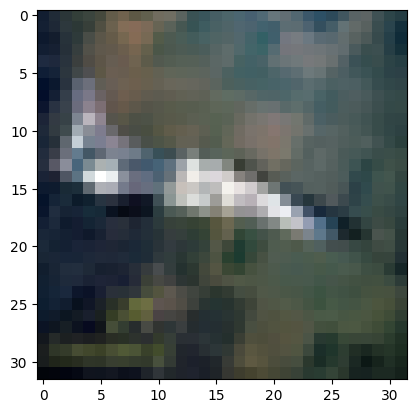

In [48]:
plt.imshow(train_dataset[3][0].permute(1, 2, 0))         # train_dataset[3] returns (image, label)
train_dataset.idx_to_class[0]

## 2.3 Simple Model (CNN + MLP)

> with simple CNNs and MLPs with non-linear activation functions

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)  # 16(out_channel) * 16(width) * 16(height)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # relut activation function : x = max(0, x)
        x = x.view(-1, 16 * 16 * 16)
        # x = nn.Flatten()(x)
        x = self.fc1(x)
        return x

### forward pass example

In [50]:
classifer = CustomModel()
print(classifer)

CustomModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
tmp_output = classifer(train_dataset[3][0].unsqueeze(0))  # (c, h, w) -> (1, c, h, w)
print(tmp_output)

tensor([[-0.0873,  0.0800, -0.0156, -0.0531,  0.0327,  0.0537,  0.1139,  0.0055,
          0.1018,  0.0316]], grad_fn=<AddmmBackward0>)


In [55]:
def pretty_print_output(tensor, label = None):
    probs = F.softmax(tensor, dim=1)
    predicted_idx = probs.argmax(dim=1).item()
    print("\n====== Model Output Info ======")
    print(f"Shape           : {tensor.shape}")
    print(f"Softmax Prob.   :\n{probs}")
    print(f"\nPredicted idex : {predicted_idx}")
    print(f"\nPredicted Class : {train_dataset.idx_to_class[predicted_idx]}")
    print(f"Real label      : {label}")
    print("=" * 30 + "\n")

pretty_print_output(tmp_output, train_dataset.idx_to_class[train_dataset[3][1]])


====== Model Output Info ======
Shape           : torch.Size([1, 10])
Softmax Prob.   :
tensor([[0.0891, 0.1053, 0.0957, 0.0922, 0.1004, 0.1026, 0.1089, 0.0978, 0.1076,
         0.1003]], grad_fn=<SoftmaxBackward0>)

Predicted idex : 6

Predicted Class : frog
Real label      : airplane



## 2.4 Loss function

- while we uses labeled data and classifier, cross entropy loss is used. <br>
`nn.CrossEntropyLoss`
- and the optimizer is SGD (Stochastic Gradient Descent) without momentum. (simplest form)
`torch.optim.SGD`

In [54]:
import torch

criterion = nn.CrossEntropyLoss()

In [56]:
loss = criterion(tmp_output, torch.tensor([train_dataset[3][1]]))           # train_dataset[3][1] = 6
print(f"Loss: {loss.item()}")           # .item() returns the value of a tensor as a standard Python number

Loss: 2.4181013107299805


## 2.5 Optimizer (steps)
0. loss calculation
1. `optimizer.zero_grad()`               # zero the gradient buffers
2. `loss.backward()`                  # backpropagation
3. `optimizer.step()`                 # update the weights

In [57]:
optimizer = torch.optim.SGD(classifer.parameters(), lr=0.01, momentum=0)
name, param = next(iter(classifer.named_parameters()))          # named_parameters() returns an iterator of (name, parameter) tuples

def print_param_info(stage, param, name):
    print(f"\n[{stage}] Parameter name: {name}")
    print(f"  shape: {param.shape}")
    print(f"  data (first 5 elements): {param.data.view(-1)[:5]}")
    print(f"  grad (first 5 elements): {param.grad.view(-1)[:5] if param.grad is not None else None}")

# 1. optimizer.zero_grad()로 grad 초기화
optimizer.zero_grad()
print_param_info("After optimizer.zero_grad()", param, name)

# 2. loss.backward()로 gradient 계산
loss.backward()
print_param_info("After loss.backward()", param, name)

# 3. optimizer.step()으로 파라미터 업데이트
optimizer.step()
print_param_info("After optimizer.step()", param, name)


[After optimizer.zero_grad()] Parameter name: conv1.weight
  shape: torch.Size([16, 3, 3, 3])
  data (first 5 elements): tensor([ 0.1471,  0.1597, -0.0451,  0.1768, -0.0422])
  grad (first 5 elements): None

[After loss.backward()] Parameter name: conv1.weight
  shape: torch.Size([16, 3, 3, 3])
  data (first 5 elements): tensor([ 0.1471,  0.1597, -0.0451,  0.1768, -0.0422])
  grad (first 5 elements): tensor([0.0546, 0.0687, 0.0394, 0.0591, 0.0750])

[After optimizer.step()] Parameter name: conv1.weight
  shape: torch.Size([16, 3, 3, 3])
  data (first 5 elements): tensor([ 0.1466,  0.1590, -0.0455,  0.1762, -0.0429])
  grad (first 5 elements): tensor([0.0546, 0.0687, 0.0394, 0.0591, 0.0750])


# Part3. full training code

1. Dataset
2. DataLooader
3. Model
4. Loss function
5. Optimizer
6. Training loop

In [58]:
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 RANDOM SEED CONFIGURATION
# ═════════════════════════════════════════════════════════════════════════════

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"        # device="mps" for MacOS, "cuda" for GPU, "cpu" for CPU
print("using device:", device)

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 DATASET AND DATALOADER
# ═════════════════════════════════════════════════════════════════════════════

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # first, collect all class names and their indices
        classes = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()} 

        # then, collect all image paths and their corresponding labels with repeating the class folders
        for cls_name in classes:
            cls_folder = os.path.join(root, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(cls_folder, fname)
                    self.samples.append((path, self.class_to_idx[cls_name]))        # adding image path and label here!

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path)          # now we open the image file using PIL
        if self.transform:
            img = self.transform(img)           # transforming PIL image to torch.Tensor
        return img, label

train_root = './cifar10_images/train'
test_root = './cifar10_images/test'

train_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_root, transform=train_transform)
test_dataset = CustomDataset(test_root, transform=test_transform)

#dataloader
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

# ═════════════════════════════════════════════════════════════════════════════
# 🏗️ MODEL ARCHITECTURE
# ═════════════════════════════════════════════════════════════════════════════

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)  # 16(out_channel) * 16(width) * 16(height)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # relut activation function : x = max(0, x)
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc1(x)
        return x

# ═════════════════════════════════════════════════════════════════════════════
# 📊 MODEL TRAINING
# ═════════════════════════════════════════════════════════════════════════════

classifier = CustomModel().to(device)

# training loop 
total_epochs = 50

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.03, momentum=0)

for epoch in range(total_epochs):
    for i, (images, labels) in enumerate(train_loader):             # enumerate returns both index(i) and value( (images, labels) )
        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{total_epochs}], Loss: {loss.item():.4f}")

using device: mps
Epoch [1/50], Loss: 2.1481
Epoch [2/50], Loss: 2.0700
Epoch [3/50], Loss: 1.9120
Epoch [4/50], Loss: 1.9082
Epoch [5/50], Loss: 1.9154
Epoch [6/50], Loss: 1.8623
Epoch [7/50], Loss: 1.7970
Epoch [8/50], Loss: 1.8253
Epoch [9/50], Loss: 1.7278
Epoch [10/50], Loss: 1.7938
Epoch [11/50], Loss: 1.7120
Epoch [12/50], Loss: 1.6844
Epoch [13/50], Loss: 1.7434
Epoch [14/50], Loss: 1.7048
Epoch [15/50], Loss: 1.6256
Epoch [16/50], Loss: 1.6541
Epoch [17/50], Loss: 1.5802
Epoch [18/50], Loss: 1.5613
Epoch [19/50], Loss: 1.5321
Epoch [20/50], Loss: 1.5614
Epoch [21/50], Loss: 1.5780
Epoch [22/50], Loss: 1.4910
Epoch [23/50], Loss: 1.4798
Epoch [24/50], Loss: 1.4882
Epoch [25/50], Loss: 1.4881
Epoch [26/50], Loss: 1.4250
Epoch [27/50], Loss: 1.4392
Epoch [28/50], Loss: 1.4607
Epoch [29/50], Loss: 1.3977
Epoch [30/50], Loss: 1.3918
Epoch [31/50], Loss: 1.3859
Epoch [32/50], Loss: 1.3979
Epoch [33/50], Loss: 1.3549
Epoch [34/50], Loss: 1.3550
Epoch [35/50], Loss: 1.3425
Epoch [36/5

## 3.1 Test Accuarcy on Test dataset

> using `test` dataset and test_dataloader evaluate
> test_dataset conatains 10,000 images

In [59]:
classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 54.32%


# Part4. Improving Model performance

### 1. 🏗️ Deeper Model Architecture
   - Add more convolutional layers
   - Implement batch normalization
   - Include dropout for regularization

### 2. 📊 Data Augmentation
   - Random horizontal flip
   - Random crop with padding
   - Normalization techniques

### 3. ⚡ Optimizer Optimization
   - Switch from SGD to Adam

In [ ]:
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 RANDOM SEED CONFIGURATION
# ═════════════════════════════════════════════════════════════════════════════

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"        # device="mps" for MacOS, "cuda" for GPU, "cpu" for CPU
print("using device:", device)

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 DATASET AND DATALOADER
# ═════════════════════════════════════════════════════════════════════════════

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # first, collect all class names and their indices
        classes = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()} 

        # then, collect all image paths and their corresponding labels with repeating the class folders
        for cls_name in classes:
            cls_folder = os.path.join(root, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(cls_folder, fname)
                    self.samples.append((path, self.class_to_idx[cls_name]))        # adding image path and label here!

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path)          # now we open the image file using PIL
        if self.transform:
            img = self.transform(img)           # transforming PIL image to torch.Tensor
        return img, label

train_root = './cifar10_images/train'
test_root = './cifar10_images/test'

# MODIFIED: Enhanced data augmentation techniques and added normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),  # MODIFIED: Added random crop
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # MODIFIED: cifar10 standard normalization
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # MODIFIED: Added normalization (same as train, cause model is trained with this normalization)
])

train_dataset = CustomDataset(train_root, transform=train_transform)
test_dataset = CustomDataset(test_root, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

# ═════════════════════════════════════════════════════════════════════════════
# 🏗️ MODEL ARCHITECTURE
# ═════════════════════════════════════════════════════════════════════════════

class CustomModel_v2(nn.Module):
    def __init__(self, num_classes=10):  # MODIFIED: Made number of classes as parameter
        super(CustomModel_v2, self).__init__()
        
        # MODIFIED: Improved with deeper network architecture
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # MODIFIED: Added Batch Normalization

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # MODIFIED: Added Batch Normalization
        
        # MODIFIED: Additional convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # MODIFIED: Adjusted dropout rate and applied to multiple locations
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
        # MODIFIED: Increased fully connected layer size
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 32x32 -> 16x16 -> 8x8 -> 4x4
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # MODIFIED: Improved forward pass with Batch Normalization
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32x32 -> 16x16

        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 16x16 -> 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 8x8 -> 4x4
        
        x = self.dropout1(x)
        x = x.view(-1, 128 * 4 * 4)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# MODIFIED: Calculate number of classes
num_classes = len(train_dataset.class_to_idx)
model = CustomModel_v2(num_classes=num_classes).to(device)          # naming `model` is proper than `classifier` for clarity

total_epochs = 50
criterion = nn.CrossEntropyLoss().to(device)

# ‼️ optimizer modi SGD to Adam for better convergence
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_losses = []  # MODIFIED: List to store training losses

for epoch in range(total_epochs):
    model.train()
    # MODIFIED: added running loss for each epoch
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):             # enumerate returns both index(i) and value( (images, labels) )
        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch + 1}/{total_epochs}]  Train Loss: {avg_loss:.4f}")

using device: mps
Epoch [1/50]  Train Loss: 1.4933
Epoch [2/50]  Train Loss: 1.1571
Epoch [3/50]  Train Loss: 1.0317
Epoch [4/50]  Train Loss: 0.9551
Epoch [5/50]  Train Loss: 0.8964
Epoch [6/50]  Train Loss: 0.8598
Epoch [7/50]  Train Loss: 0.8247
Epoch [8/50]  Train Loss: 0.7926
Epoch [9/50]  Train Loss: 0.7715
Epoch [10/50]  Train Loss: 0.7417
Epoch [11/50]  Train Loss: 0.7281
Epoch [12/50]  Train Loss: 0.7019
Epoch [13/50]  Train Loss: 0.6876
Epoch [14/50]  Train Loss: 0.6724
Epoch [15/50]  Train Loss: 0.6604
Epoch [16/50]  Train Loss: 0.6458
Epoch [17/50]  Train Loss: 0.6251
Epoch [18/50]  Train Loss: 0.6218
Epoch [19/50]  Train Loss: 0.6080
Epoch [20/50]  Train Loss: 0.5992
Epoch [21/50]  Train Loss: 0.5902
Epoch [22/50]  Train Loss: 0.5781
Epoch [23/50]  Train Loss: 0.5743
Epoch [24/50]  Train Loss: 0.5630
Epoch [25/50]  Train Loss: 0.5567
Epoch [26/50]  Train Loss: 0.5523
Epoch [27/50]  Train Loss: 0.5456
Epoch [28/50]  Train Loss: 0.5415
Epoch [29/50]  Train Loss: 0.5356
Epoch

NameError: name 'plt' is not defined

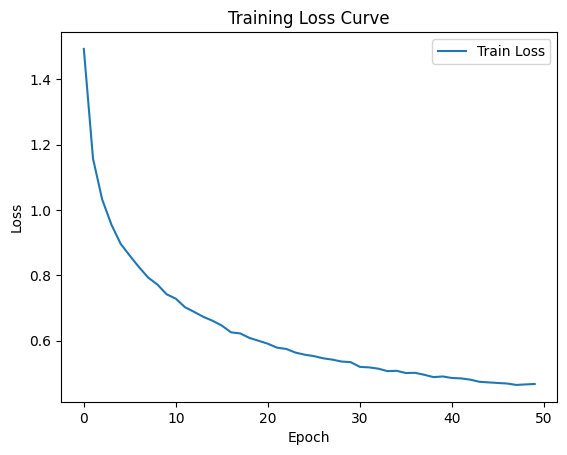

In [2]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [3]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.47%


## 4.2 checkpoint

> saving the model

In [4]:
torch.save(model.state_dict(), 'model_checkpoint.pth')

> loading the model

In [11]:
model_loaded = CustomModel_v2(num_classes=num_classes).to(device)  # create a new instance of the model
checkpoint = torch.load('model_checkpoint.pth')
# print(checkpoint)
model_loaded.load_state_dict(checkpoint)

<All keys matched successfully>

> onnx form saving

you can visualize in the [Netron](https://netron.app/)

In [9]:
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # 입력 크기와 맞춰서 설정
torch.onnx.export(model, dummy_input, 'model_checkpoint.onnx')

# Part5. (Day3) Practical Tools in Code

## 5.1 tqdm + compute_effi + scheduler + optimizer

In [22]:
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image

from tqdm import tqdm
import time

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 RANDOM SEED CONFIGURATION
# ═════════════════════════════════════════════════════════════════════════════

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print("using device:", device)

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 DATASET AND DATALOADER
# ═════════════════════════════════════════════════════════════════════════════

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # first, collect all class names and their indices
        classes = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()} 

        # then, collect all image paths and their corresponding labels with repeating the class folders
        for cls_name in classes:
            cls_folder = os.path.join(root, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(cls_folder, fname)
                    self.samples.append((path, self.class_to_idx[cls_name]))        # adding image path and label here!

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path)          # now we open the image file using PIL
        if self.transform:
            img = self.transform(img)           # transforming PIL image to torch.Tensor
        return img, label

train_root = './cifar10_images/train'
test_root = './cifar10_images/test'

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CustomDataset(train_root, transform=train_transform)
test_dataset = CustomDataset(test_root, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

# ═════════════════════════════════════════════════════════════════════════════
# 🏗️ MODEL ARCHITECTURE
# ═════════════════════════════════════════════════════════════════════════════

class CustomModel_v2(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel_v2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
    
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = self.dropout1(x)
        x = x.view(-1, 128 * 4 * 4)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_classes = len(train_dataset.class_to_idx)
model = CustomModel_v2(num_classes=num_classes).to(device)

total_epochs = 50
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_losses = []

try:
    for epoch in range(total_epochs):
        model.train()
        running_loss = 0.0
        compute_effi = 0.0

        load_start = time.time()

        pbar = tqdm(total=len(train_loader))

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)

            load_time = time.time() - load_start
            compute_start = time.time()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            compute_time = time.time() - compute_start

            running_loss += loss.item()
            computational_efficiency = compute_time / (load_time + compute_time)
            compute_effi += computational_efficiency

            pbar.set_postfix({
                'Loss' : f"{loss.item():.4f}",
                'compute effi.' : f"{(computational_efficiency)*100:.2f}%",
            })
            pbar.update(1)
            load_start = time.time()

        avg_loss = running_loss / len(train_loader)
        avg_compute_effi = compute_effi / len(train_loader)
        train_losses.append(avg_loss)

        print(f"Epoch [{epoch + 1}/{total_epochs}]  Train Loss: {avg_loss:.4f}  Avg Compute Efficiency: {avg_compute_effi*100:.2f}%")
    pbar.close()
    
except KeyboardInterrupt:
    pbar.close()
    print("\nTraining interrupted by user.")

using device: mps


100%|█████████▉| 1562/1563 [00:41<00:00, 36.70it/s, Loss=0.8897, compute effi.=95.13%]

Epoch [1/50]  Train Loss: 1.5042  Avg Compute Efficiency: 47.06%



100%|██████████| 1563/1563 [00:41<00:00, 37.77it/s, Loss=0.8897, compute effi.=95.13%]
























































































































  6%|▌         | 96/1563 [00:02<00:44, 32.89it/s, Loss=1.2534, compute effi.=82.15%]


Training interrupted by user.


## 5.2 Completed code (applied things that we have learned so far)

In [23]:
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image

# [NEW] imports for 5.1
from tqdm import tqdm                   # for tqdm
import time                             # for computation efficiency
from torch.utils.data import Subset     # for Subset
from prefetch_generator import BackgroundGenerator

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 RANDOM SEED CONFIGURATION
# ═════════════════════════════════════════════════════════════════════════════

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print("using device:", device)

# ═════════════════════════════════════════════════════════════════════════════
# 🎯 DATASET AND DATALOADER
# ═════════════════════════════════════════════════════════════════════════════

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # first, collect all class names and their indices
        classes = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()} 

        # then, collect all image paths and their corresponding labels with repeating the class folders
        for cls_name in classes:
            cls_folder = os.path.join(root, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(cls_folder, fname)
                    self.samples.append((path, self.class_to_idx[cls_name]))        # adding image path and label here!

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path)          # now we open the image file using PIL
        if self.transform:
            img = self.transform(img)           # transforming PIL image to torch.Tensor
        return img, label

train_root = './cifar10_images/train'
test_root = './cifar10_images/test'

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CustomDataset(train_root, transform=train_transform)
test_dataset = CustomDataset(test_root, transform=test_transform)

# [NEW] Validation dataset
num_samples = len(train_dataset)
indices = np.arange(num_samples)
np.random.shuffle(indices)

split = int(np.floor(0.1 * num_samples))
val_indices = indices[:split]
train_indices = indices[split:]

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# ═════════════════════════════════════════════════════════════════════════════
# 🏗️ MODEL ARCHITECTURE
# ═════════════════════════════════════════════════════════════════════════════

class CustomModel_v2(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel_v2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
    
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = self.dropout1(x)
        x = x.view(-1, 128 * 4 * 4)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_classes = len(train_dataset.class_to_idx)
model = CustomModel_v2(num_classes=num_classes).to(device)

total_epochs = 50
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# [NEW] Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
best_val_accuracy = 0.0

try:
    for epoch in range(total_epochs):
        model.train()
        running_loss = 0.0
        compute_efficiencies = []

        # [NEW] tqdm progress bar
        pbar = tqdm(total=len(train_loader), desc=f'Epoch[{epoch + 1}/{total_epochs}]')

        # [NEW] computation efficiency
        start_time = time.time()

        # [NEW] BackgroundGenerator for prefetching
        for i, (images, labels) in enumerate(BackgroundGenerator(train_loader)):
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)

            prepare_time = time.time() - start_time

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            compute_time = time.time() - start_time - prepare_time

            running_loss += loss.item()
            compute_efficiency = compute_time / (prepare_time + compute_time)
            compute_efficiencies.append(compute_efficiency)

            pbar.set_postfix({
                'Loss' : f'{loss.item():.4f}',
                'Compute_efficiency' : f'{compute_efficiency:.2f}',
                }
            )
            
            pbar.update(1)

            start_time = time.time()

        pbar.close()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        average_compute_efficiency = sum(compute_efficiencies) / len(compute_efficiencies) if compute_efficiencies else 0

        print(f"Train Loss: {avg_loss:.4f} | Avg Computational Effi: {average_compute_efficiency:.3f}")

        # [NEW] Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            pbar = tqdm(total=len(val_loader), desc=f'Validation [{epoch + 1}/{total_epochs}]')
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar.update(1)
                
        pbar.close()
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

        print(f"Val loss: {val_loss:.4f} | Accuracy(val): {val_accuracy:.2f}%")
    
        # [NEW] Best model checkpoint
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # pt save
            torch.save(model.state_dict(), "best_model.pt")
            # onnx export
            dummy_input = torch.randn(1, 3, 32, 32, device=device)
            torch.onnx.export(model, dummy_input, "best_model.onnx")
            print(f"Best model saved at epoch {epoch+1} with accuracy {best_val_accuracy:.2f}%")

        print("\n")

        # [NEW] Step the learning rate scheduler
        scheduler.step()
        
except KeyboardInterrupt:
    pbar.close()
    print("\nTraining interrupted by user.")

using device: mps


Epoch[1/50]: 100%|██████████| 1407/1407 [00:23<00:00, 59.76it/s, Loss=0.6370, Compute_efficiency=1.00]


Train Loss: 1.5249 | Avg Computational Effi: 0.915


Validation [1/50]: 100%|██████████| 157/157 [00:02<00:00, 67.10it/s]


Val loss: 1.2616 | Accuracy(val): 54.54%
Best model saved at epoch 1 with accuracy 54.54%




Epoch[2/50]: 100%|██████████| 1407/1407 [00:22<00:00, 62.12it/s, Loss=0.7729, Compute_efficiency=0.90]


Train Loss: 1.2068 | Avg Computational Effi: 0.921


Validation [2/50]: 100%|██████████| 157/157 [00:02<00:00, 64.85it/s]


Val loss: 1.0654 | Accuracy(val): 62.74%
Best model saved at epoch 2 with accuracy 62.74%




Epoch[3/50]: 100%|██████████| 1407/1407 [00:24<00:00, 58.26it/s, Loss=0.5956, Compute_efficiency=0.93]


Train Loss: 1.0711 | Avg Computational Effi: 0.919


Validation [3/50]: 100%|██████████| 157/157 [00:02<00:00, 62.74it/s]


Val loss: 0.9732 | Accuracy(val): 65.08%
Best model saved at epoch 3 with accuracy 65.08%




Epoch[4/50]: 100%|██████████| 1407/1407 [00:28<00:00, 50.23it/s, Loss=1.0221, Compute_efficiency=0.93]


Train Loss: 0.9877 | Avg Computational Effi: 0.926


Validation [4/50]: 100%|██████████| 157/157 [00:02<00:00, 59.77it/s]


Val loss: 0.9302 | Accuracy(val): 67.18%
Best model saved at epoch 4 with accuracy 67.18%




Epoch[5/50]: 100%|██████████| 1407/1407 [00:37<00:00, 37.30it/s, Loss=0.8818, Compute_efficiency=0.95]


Train Loss: 0.9310 | Avg Computational Effi: 0.933


Validation [5/50]: 100%|██████████| 157/157 [00:03<00:00, 51.61it/s]


Val loss: 0.8672 | Accuracy(val): 70.16%
Best model saved at epoch 5 with accuracy 70.16%




Epoch[6/50]: 100%|██████████| 1407/1407 [00:38<00:00, 36.71it/s, Loss=0.6606, Compute_efficiency=0.95]


Train Loss: 0.8785 | Avg Computational Effi: 0.938


Validation [6/50]: 100%|██████████| 157/157 [00:03<00:00, 50.92it/s]


Val loss: 0.8110 | Accuracy(val): 72.86%
Best model saved at epoch 6 with accuracy 72.86%




Epoch[7/50]: 100%|██████████| 1407/1407 [00:34<00:00, 40.92it/s, Loss=0.6445, Compute_efficiency=0.96]


Train Loss: 0.8422 | Avg Computational Effi: 0.937


Validation [7/50]: 100%|██████████| 157/157 [00:03<00:00, 51.48it/s]


Val loss: 0.7970 | Accuracy(val): 72.66%




Epoch[8/50]: 100%|██████████| 1407/1407 [00:31<00:00, 44.13it/s, Loss=0.3354, Compute_efficiency=0.91]


Train Loss: 0.8070 | Avg Computational Effi: 0.939


Validation [8/50]: 100%|██████████| 157/157 [00:02<00:00, 56.40it/s]


Val loss: 0.7981 | Accuracy(val): 72.34%




Epoch[9/50]: 100%|██████████| 1407/1407 [00:31<00:00, 45.06it/s, Loss=0.8739, Compute_efficiency=0.93]


Train Loss: 0.7768 | Avg Computational Effi: 0.938


Validation [9/50]: 100%|██████████| 157/157 [00:02<00:00, 65.99it/s]


Val loss: 0.6948 | Accuracy(val): 76.36%
Best model saved at epoch 9 with accuracy 76.36%




Epoch[10/50]: 100%|██████████| 1407/1407 [00:26<00:00, 53.47it/s, Loss=0.6147, Compute_efficiency=0.95]


Train Loss: 0.7579 | Avg Computational Effi: 0.940


Validation [10/50]: 100%|██████████| 157/157 [00:03<00:00, 41.18it/s]


Val loss: 0.6976 | Accuracy(val): 75.52%




Epoch[11/50]: 100%|██████████| 1407/1407 [00:29<00:00, 48.39it/s, Loss=1.2567, Compute_efficiency=0.96]


Train Loss: 0.6569 | Avg Computational Effi: 0.939


Validation [11/50]: 100%|██████████| 157/157 [00:02<00:00, 55.07it/s]


Val loss: 0.6233 | Accuracy(val): 78.44%
Best model saved at epoch 11 with accuracy 78.44%




Epoch[12/50]: 100%|██████████| 1407/1407 [00:33<00:00, 41.55it/s, Loss=0.5375, Compute_efficiency=0.95]


Train Loss: 0.6317 | Avg Computational Effi: 0.939


Validation [12/50]: 100%|██████████| 157/157 [00:03<00:00, 51.08it/s]


Val loss: 0.6051 | Accuracy(val): 79.64%
Best model saved at epoch 12 with accuracy 79.64%




Epoch[13/50]: 100%|██████████| 1407/1407 [00:32<00:00, 43.45it/s, Loss=0.4562, Compute_efficiency=0.89]


Train Loss: 0.6196 | Avg Computational Effi: 0.940


Validation [13/50]: 100%|██████████| 157/157 [00:03<00:00, 49.45it/s]


Val loss: 0.5897 | Accuracy(val): 79.56%




Epoch[14/50]: 100%|██████████| 1407/1407 [00:45<00:00, 31.21it/s, Loss=1.0351, Compute_efficiency=0.94]


Train Loss: 0.6064 | Avg Computational Effi: 0.937


Validation [14/50]: 100%|██████████| 157/157 [00:03<00:00, 40.43it/s]


Val loss: 0.5799 | Accuracy(val): 79.92%
Best model saved at epoch 14 with accuracy 79.92%




Epoch[15/50]: 100%|██████████| 1407/1407 [00:54<00:00, 25.64it/s, Loss=0.2943, Compute_efficiency=0.96]


Train Loss: 0.5970 | Avg Computational Effi: 0.934


Validation [15/50]: 100%|██████████| 157/157 [00:03<00:00, 42.75it/s]


Val loss: 0.5792 | Accuracy(val): 79.90%




Epoch[16/50]: 100%|██████████| 1407/1407 [00:53<00:00, 26.31it/s, Loss=0.9822, Compute_efficiency=0.93]


Train Loss: 0.5846 | Avg Computational Effi: 0.934


Validation [16/50]: 100%|██████████| 157/157 [00:04<00:00, 39.11it/s]


Val loss: 0.5715 | Accuracy(val): 80.06%
Best model saved at epoch 16 with accuracy 80.06%




Epoch[17/50]: 100%|██████████| 1407/1407 [00:53<00:00, 26.14it/s, Loss=0.8188, Compute_efficiency=0.94]


Train Loss: 0.5827 | Avg Computational Effi: 0.933


Validation [17/50]: 100%|██████████| 157/157 [00:03<00:00, 39.53it/s]


Val loss: 0.5619 | Accuracy(val): 81.08%
Best model saved at epoch 17 with accuracy 81.08%




Epoch[18/50]: 100%|██████████| 1407/1407 [01:01<00:00, 23.05it/s, Loss=0.5504, Compute_efficiency=0.97]


Train Loss: 0.5726 | Avg Computational Effi: 0.936


Validation [18/50]: 100%|██████████| 157/157 [00:04<00:00, 39.12it/s]


Val loss: 0.5619 | Accuracy(val): 80.90%




Epoch[19/50]: 100%|██████████| 1407/1407 [00:59<00:00, 23.51it/s, Loss=1.2039, Compute_efficiency=0.95]


Train Loss: 0.5689 | Avg Computational Effi: 0.935


Validation [19/50]: 100%|██████████| 157/157 [00:03<00:00, 40.02it/s]


Val loss: 0.5470 | Accuracy(val): 80.92%




Epoch[20/50]: 100%|██████████| 1407/1407 [01:00<00:00, 23.13it/s, Loss=0.9593, Compute_efficiency=0.96]


Train Loss: 0.5638 | Avg Computational Effi: 0.934


Validation [20/50]: 100%|██████████| 157/157 [00:03<00:00, 42.91it/s]


Val loss: 0.5614 | Accuracy(val): 80.60%




Epoch[21/50]: 100%|██████████| 1407/1407 [01:05<00:00, 21.55it/s, Loss=0.4882, Compute_efficiency=0.92]


Train Loss: 0.5507 | Avg Computational Effi: 0.936


Validation [21/50]: 100%|██████████| 157/157 [00:03<00:00, 41.33it/s]


Val loss: 0.5487 | Accuracy(val): 81.24%
Best model saved at epoch 21 with accuracy 81.24%




Epoch[22/50]: 100%|██████████| 1407/1407 [01:06<00:00, 21.03it/s, Loss=0.4643, Compute_efficiency=0.97]


Train Loss: 0.5457 | Avg Computational Effi: 0.937


Validation [22/50]: 100%|██████████| 157/157 [00:03<00:00, 44.75it/s]


Val loss: 0.5463 | Accuracy(val): 81.94%
Best model saved at epoch 22 with accuracy 81.94%




Epoch[23/50]: 100%|██████████| 1407/1407 [01:06<00:00, 21.19it/s, Loss=0.6494, Compute_efficiency=0.89]


Train Loss: 0.5482 | Avg Computational Effi: 0.936


Validation [23/50]: 100%|██████████| 157/157 [00:03<00:00, 41.97it/s]


Val loss: 0.5525 | Accuracy(val): 80.94%




Epoch[24/50]: 100%|██████████| 1407/1407 [01:03<00:00, 22.03it/s, Loss=1.0424, Compute_efficiency=0.86]


Train Loss: 0.5457 | Avg Computational Effi: 0.938


Validation [24/50]: 100%|██████████| 157/157 [00:03<00:00, 41.70it/s]


Val loss: 0.5499 | Accuracy(val): 81.66%




Epoch[25/50]: 100%|██████████| 1407/1407 [01:06<00:00, 21.11it/s, Loss=0.6259, Compute_efficiency=0.97]


Train Loss: 0.5476 | Avg Computational Effi: 0.939


Validation [25/50]: 100%|██████████| 157/157 [00:04<00:00, 37.86it/s]


Val loss: 0.5464 | Accuracy(val): 81.24%




Epoch[26/50]:  75%|███████▍  | 1053/1407 [00:53<00:17, 19.77it/s, Loss=0.4590, Compute_efficiency=0.99]


Training interrupted by user.
